# Network inference under noisy channels

Under noiseless hardware, it seems that covariance methods reign supreme over entropic quantities by both computational complexity and performance. We hope to find regimes for which studying entropic quantities are advantageous. 

The intuition for examining noisy quantum channels is as follows. Covariance is a linear operator. It captures the linear relationship between two random variables. Mutual information also quantifies the amount of correlation between random quantities, but it assumes no linearity. Thus, I suspect when the linear formalism of quantum mechanics break down, the performance of covariance-based inference will decline, and perhaps more so than entropy-based methods.

In [93]:
import qnetti
import pennylane as qml
from pennylane import numpy as qnp
import qnetvo
import matplotlib.pyplot as plt

print(qnetvo.__version__)
print(qml.__version__)

0.4.1
0.28.0


In [94]:
def decision_matrix(mat, atol=0.1):
    return qnp.where(qnp.abs(mat) > atol, 1, 0)


def matrix_distance(mat1, mat2):
    return qnp.linalg.norm(qnp.array(mat1) - qnp.abs(qnp.array(mat2)))


def characteristic_matrix_inference(prep_node, expected_mat, print_result=True, **kwargs):
    char_mat = qnetti.qubit_characteristic_matrix(prep_node, **kwargs)
    dec_mat = decision_matrix(char_mat)
    char_dist = matrix_distance(expected_mat, char_mat)

    if print_result:
        print("characteristic matrix :\n", char_mat)
        print("decision matrix :\n", dec_mat)
        print("expected matrix :\n", expected_mat)
        print("distance to expected : ", char_dist)
    
    return char_mat


def covariance_matrix_inference(
    prep_node,
    num_qubits,
    expected_mat,
    meas_wires=None,
    step_size=0.1,
    num_steps=10,
    verbose=False,
    shots=None,
    qnode_kwargs={},
    atol=0.1,
    print_result=True
):
    settings = qnp.random.rand(3 * num_qubits, requires_grad=True)
    cov_cost = qnetti.qubit_covariance_cost_fn(
        prep_node, meas_wires=meas_wires, shots=shots, qnode_kwargs=qnode_kwargs
    )

    settings_list = [settings]
    cost_vals = [cov_cost(settings)]

    opt = qml.GradientDescentOptimizer(stepsize=step_size)
    for i in range(num_steps):
        settings, cost_val = opt.step_and_cost(cov_cost, settings)

        cost_vals += [cost_val]
        settings_list += [settings]

    min_id = qnp.argmin(cost_vals)
    min_cost = cost_vals[min_id]
    opt_settings = settings_list[min_id]

    cov_mat = qnetti.qubit_covariance_matrix_fn(
        prep_node, meas_wires=meas_wires, shots=shots, qnode_kwargs=qnode_kwargs
    )(opt_settings)
    dec_mat = decision_matrix(cov_mat, atol=atol)
    cov_dist = matrix_distance(expected_mat, cov_mat)
    
    if print_result:
        print("covariance matrix :\n", cov_mat)
        print("decision matrix :\n", dec_mat)
        print("expected matrix :\n", expected_mat)
        print("distance to expected : ", cov_dist)

    return cov_mat

## Theoretical Values for Measured Mutual Information and Covariance

We will calculate the theoretical values for both mutual information and covariance for the purposes of verifying the optimization results. Each function takes in 1) the state (density matrix) prepared by the network $\rho$, and 2) the Kraus operators of the quantum channel $\{K_i\}$ (often parameterized by a noise parameter $\gamma \in [0,1]$) such that $\mathcal E(\rho) = \sum_i K_i \rho K_i^\dagger$.

**Note: this is probably not needed upon tweaking qnetti source code. But, I'll write this quick implementation to avoid merge conflicts.

## 2-qubit Bell states

We begin investigation of noise using a simple two-node, two-qubit network with Bell state preparation. 
Throughtout the notebook, I'll use $\mathcal E$ to denote the noisy channel. 

### Depolarizing noise 

Depolarizing noise features a noise parameter $\gamma \in [0,1]$ and the Kraus operators $K_i$ for $i \in \{0,1,2,3\}$ defined by
\begin{align}
K_0 = \sqrt{\frac{3}{4}\gamma} I_2,~~ K_1 = \sqrt{\frac{\gamma}{4}} Z, ~~ K_2 = \sqrt{\frac{\gamma}{4}} Y, ~~ K_3 = \sqrt{\frac{\gamma}{4}} Z
\end{align}
where $\{I,X,Y,Z\}$ is the Pauli basis.

In [95]:
ghz2_mat = qnp.ones((2, 2))

qnp.random.seed(100)

def depolarizing_prep_node(gam):
    def rot_bell_state(settings, wires):
        qnetvo.ghz_state(settings, wires)
        qml.ArbitraryUnitary([qnp.pi / 4, 0.3, -1.5], wires=[wires[0]])
        qml.ArbitraryUnitary([-0.7, 2.9, 1.2], wires=[wires[1]])
        qml.DepolarizingChannel(3/4*gam, wires=[wires[0]])
        qml.DepolarizingChannel(3/4*gam, wires=[wires[1]])
        
    bell_state_prep_node = qnetvo.PrepareNode(wires=[0, 1], ansatz_fn=rot_bell_state)
    return bell_state_prep_node

Applying qubit-depolarizing noise to the Bell state results in the state $\mathcal E(\rho_\Phi) = \gamma(2-\gamma) I_4/4 + (1-\gamma)^2 \rho_\Phi$. Measuring each qubit optimally admits measured mutual information 
\begin{align}
\frac{1 + (1-\gamma)^2}{2} \log \left( 1 + (1-\gamma)^2 \right) + \frac{\gamma (2 - \gamma)}{2} \log \left(\gamma (2-\gamma) \right)
\end{align}
and covariance
\begin{align}
(1-\gamma)^2.
\end{align}


In [66]:
def my_log(x): 
    if x == 0:
        return 0
    else: 
        return qnp.log2(x)
        
def depolarizing_cov(gam):
    return (1-gam)**2

def depolarizing_mmi(gam):
    return (1 + (1-gam)**2)*my_log(1+(1-gam)**2)/2 + gam*(2-gam)*my_log(gam*(2-gam))/2

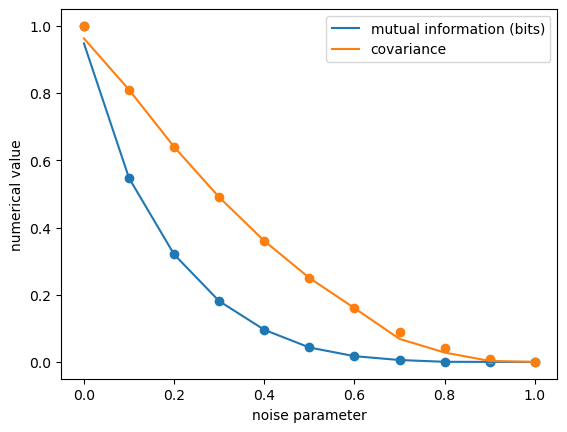

In [69]:
gamma = [x/10 for x in range(11)]
char_mat_data = [characteristic_matrix_inference(depolarizing_prep_node(gam), ghz2_mat, num_steps=40, step_size=0.5, print_result=False, qnode_kwargs={}) for gam in gamma]
cov_mat_data = [covariance_matrix_inference(depolarizing_prep_node(gam), 2, ghz2_mat, step_size=0.5, num_steps=40, verbose=False, print_result=False) for gam in gamma]

plt.plot(gamma, [mat[0,1] for mat in char_mat_data], label='mutual information (bits)')
plt.plot(gamma, [abs(mat[0,1]) for mat in cov_mat_data], label='covariance')
plt.scatter(gamma, [depolarizing_mmi(gam) for gam in gamma])
plt.scatter(gamma, [depolarizing_cov(gam) for gam in gamma])
plt.xlabel('noise parameter')
plt.ylabel('numerical value')
plt.legend() 

### Amplitude Damping 

Applying qubit-wise amplitude-damping noise to $\rho_\Phi$ results in the state
\begin{align}
\mathcal E (\rho_\Phi) = \frac{1}{2} \begin{pmatrix} 1 + \gamma^2 & 0 & 0 & 1-\gamma \\ 0 & \gamma(1-\gamma) & 0 & 0 \\ 0 & \gamma\sqrt{1-\gamma} & \gamma(1-\gamma) & 0 \\ 0 & 0 & 0 & (1-\gamma)^2 \end{pmatrix}.
\end{align}
Thus, if we measure in the computational basis (optimal?), we would observe measured mutual information of the form 
\begin{align}
\frac{1+\gamma^2}{2}\log \left( 1+\gamma^2 \right) + \gamma(1-\gamma) \log \left( \gamma(1-\gamma) \right) + \frac{(1-\gamma)^2}{2} \log \left(1-\gamma \right)^2
\end{align}


In [99]:
def amplitude_damping_prep_node(gam):
    def rot_bell_state(settings, wires):
        qnetvo.ghz_state(settings, wires)
        qml.ArbitraryUnitary([qnp.pi / 4, 0.3, -1.5], wires=[wires[0]])
        qml.ArbitraryUnitary([-0.7, 2.9, 1.2], wires=[wires[1]])
        qml.AmplitudeDamping(gam, wires=[wires[0]])
        qml.AmplitudeDamping(gam, wires=[wires[1]])
        
    bell_state_prep_node = qnetvo.PrepareNode(wires=[0, 1], ansatz_fn=rot_bell_state)
    return bell_state_prep_node

def amp_damp_mmi(gam):
    HX = -(gam*my_log(gam) + (1-gam)*my_log(1-gam))
    nHXY = (1+gam**2)*my_log((1+gam**2)/2)/2 + gam*(1-gam)*my_log(gam*(1-gam)/2) + (1-gam)**2*my_log((1-gam)**2/2)/2
    return 2*HX + nHXY

def amp_damp_cov(gam):
    return abs(1 + 2*gam**2 - 2*gam)

In [109]:
def amp_damp_mmi(gam):
    meas_nodes = [qnetvo.MeasureNode(wires=[0], ansatz_fn=qml.ArbitraryUnitary, num_settings=3),
                  qnetvo.MeasureNode(wires=[1], ansatz_fn=qml.ArbitraryUnitary, num_settings=3)]
    mmi = qnetti.measured_mutual_info_cost_fn(qnetvo.NetworkAnsatz([amplitude_damping_prep_node(gam)], meas_nodes))
    return mmi([0,0,0,0,0,0])

def amp_damp_cov(gam):
    cov_cost = qnetti.qubit_covariance_cost_fn(amplitude_damping_prep_node(gam), meas_wires=[0,1])
    return cov_cost([0,0,0,0,0,0])

amp_damp_cov(0.5)

-1.2160595771050944

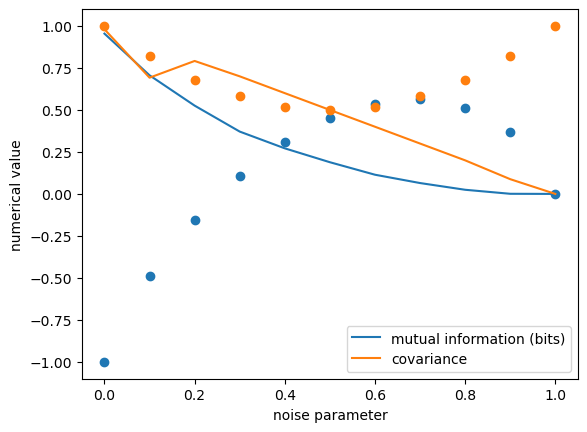

In [97]:
gamma = [x/10 for x in range(11)]
char_mat_data = [characteristic_matrix_inference(amplitude_damping_prep_node(gam), ghz2_mat, num_steps=50, step_size=0.5, print_result=False, qnode_kwargs={}) for gam in gamma]
cov_mat_data = [covariance_matrix_inference(amplitude_damping_prep_node(gam), 2, ghz2_mat, step_size=0.5, num_steps=50, verbose=False, print_result=False) for gam in gamma]

plt.plot(gamma, [mat[0,1] for mat in char_mat_data], label='mutual information (bits)')
plt.plot(gamma, [abs(mat[0,1]) for mat in cov_mat_data], label='covariance')
plt.scatter(gamma, [amp_damp_mmi(gam) for gam in gamma])
plt.scatter(gamma, [amp_damp_cov(gam) for gam in gamma])
plt.xlabel('noise parameter')
plt.ylabel('numerical value')
plt.legend()

### Phase Flip Channel 



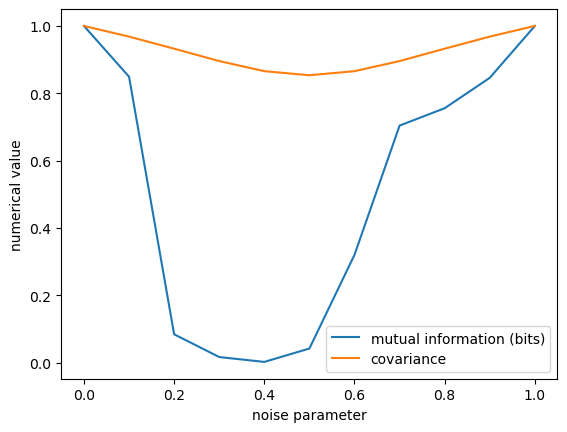

In [98]:
def phase_flip_prep_node(gam):
    def rot_bell_state(settings, wires):
        qnetvo.ghz_state(settings, wires)
        qml.ArbitraryUnitary([qnp.pi / 4, 0.3, -1.5], wires=[wires[0]])
        qml.ArbitraryUnitary([-0.7, 2.9, 1.2], wires=[wires[1]])
        qml.PhaseFlip(gam, wires=[wires[0]])
        qml.PhaseFlip(gam, wires=[wires[1]])
        
    bell_state_prep_node = qnetvo.PrepareNode(wires=[0, 1], ansatz_fn=rot_bell_state)
    return bell_state_prep_node

gamma = [x/10 for x in range(11)]
char_mat_data = [characteristic_matrix_inference(phase_flip_prep_node(gam), ghz2_mat, num_steps=50, step_size=0.1, print_result=False, qnode_kwargs={}) for gam in gamma]
cov_mat_data = [covariance_matrix_inference(phase_flip_prep_node(gam), 2, ghz2_mat, step_size=0.2, num_steps=50, verbose=False, print_result=False) for gam in gamma]

plt.plot(gamma, [mat[0,1] for mat in char_mat_data], label='mutual information (bits)')
plt.plot(gamma, [abs(mat[0,1]) for mat in cov_mat_data], label='covariance')
plt.xlabel('noise parameter')
plt.ylabel('numerical value')
plt.legend()